In [1]:
import glob
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVALUATION_FRAMES_DIR = DATA_DIR / "eval_filtered" / "dev"

In [2]:
eval_categories = sorted(os.listdir(EVALUATION_FRAMES_DIR))
print(eval_categories)

['ball', 'basket', 'car', 'cat', 'chair', 'computer', 'crib', 'door', 'floor', 'foot', 'ground', 'hand', 'kitchen', 'paper', 'puzzle', 'road', 'room', 'sand', 'stairs', 'table', 'toy', 'window']


hand


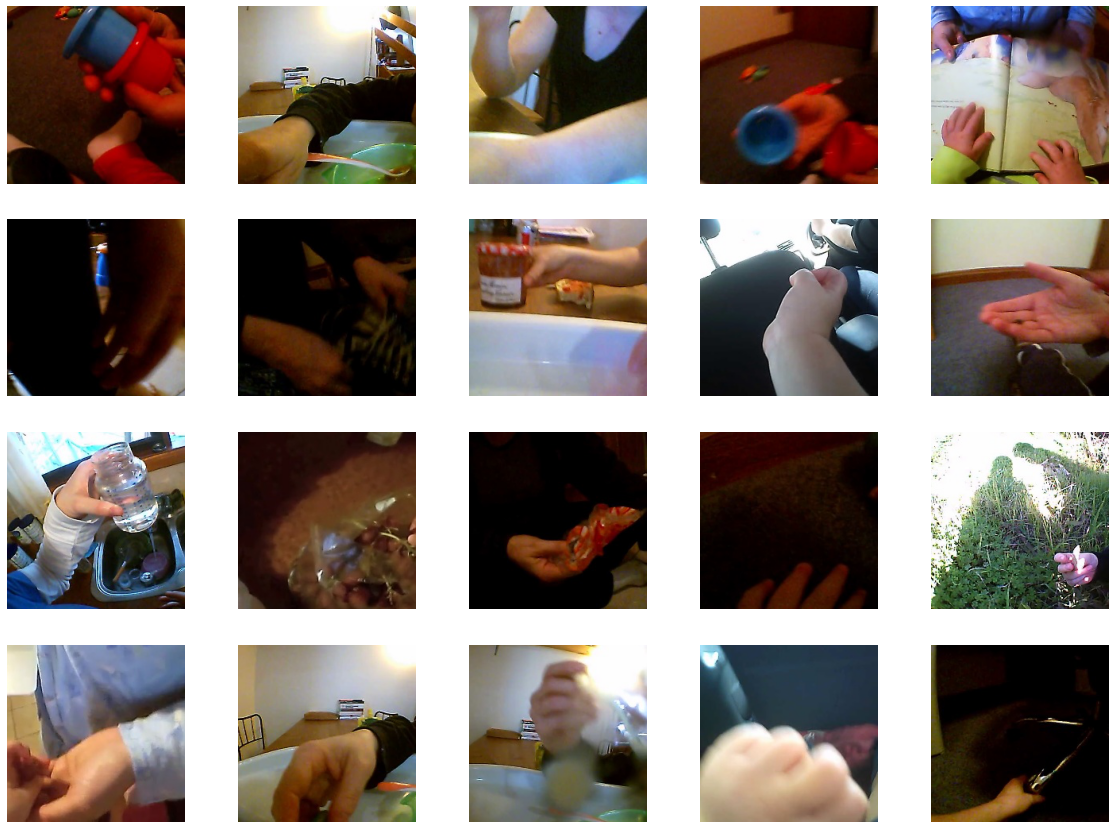

In [3]:
eval_category = np.random.choice(eval_categories)
print(eval_category)
frames = glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg"))
subset = np.random.choice(frames, size=20, replace=False)

plt.figure(figsize=(20, 15))
for i, frame in enumerate(subset):
    plt.subplot(4, 5, i+1)
    I = Image.open(frame)
    plt.imshow(I)
    plt.axis('off')


In [12]:
import torch
from torchvision import transforms
from multimodal.multimodal_lit import MultiModalLitModel
import clip
from sklearn.manifold import TSNE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
normalizer = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# load CLIP
# model, preprocess = clip.load("ViT-B/16", device=device)
# model.eval()

preprocess = transforms.Compose([
            transforms.Resize((224, 224),
                              interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            normalizer,
        ])

# load embedding checkpoint
checkpoint_name = f"multimodal_text_encoder_embedding_embedding_dim_512_batch_size_8_dropout_i_0.5_lr_5e-05_lr_scheduler_True_weight_decay_0.1_max_epochs_400_seed_0"
checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{checkpoint_name}/epoch*.ckpt")[0]
model = MultiModalLitModel.load_from_checkpoint(checkpoint, map_location=device)
model.eval()

MultiModalLitModel(
  (vision_encoder): VisionEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [4]:
all_image_features = []

for eval_category in eval_categories:
    frames = sorted(glob.glob(os.path.join(EVALUATION_FRAMES_DIR, eval_category, "*.jpeg")))
    print(eval_category, len(frames))
    subset = np.random.choice(frames, size=100, replace=True)
    
    for frame in subset:
        I = preprocess(Image.open(frame).convert('RGB')).unsqueeze(0).to(device)
        # image_features, _ = model.model.encode_image(I)
        image_features = model.encode_image(I)
        all_image_features.append(image_features.squeeze().detach().cpu().numpy())

ball 567
basket 47
car 332
cat 346
chair 181
computer 412
crib 157
door 108
floor 872
foot 184
ground 587
hand 380
kitchen 460
paper 256
puzzle 899
road 931
room 280
sand 209
stairs 150
table 564
toy 1402
window 249


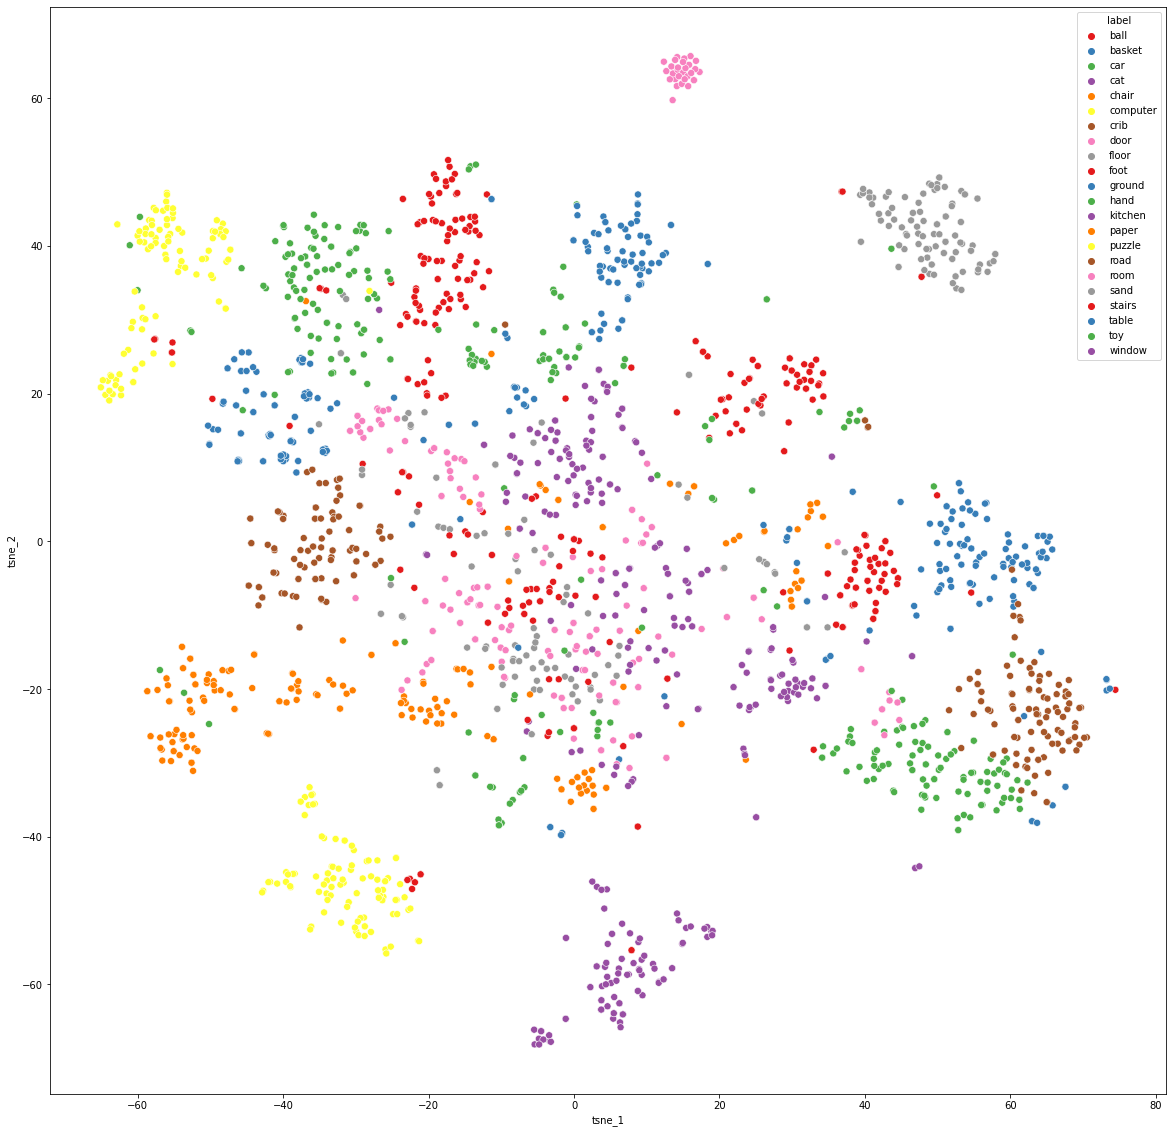

In [8]:
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("Set1", len(eval_categories)))

y = []
for eval_category in eval_categories:
    for j in range(100):
        y.append(eval_category)

# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(all_image_features)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig = plt.figure(figsize=(20, 20))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=50, legend="full")
lim = (tsne_result.min()-5, tsne_result.max()+5)

In [49]:
# get utterance embeddings
from pathlib import Path
import json
from multimodal.multimodal_data_module import SOS_TOKEN, EOS_TOKEN, UNK_TOKEN_ID

DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
VAL_METADATA_FILENAME = DATA_DIR / "val.json"
VOCAB_FILENAME = DATA_DIR / "vocab.json"

with open(VAL_METADATA_FILENAME) as f:
    data = json.load(f)
    
with open(VOCAB_FILENAME) as f:
    vocab = json.load(f)
    
val_data = data["data"]
utterances = [data['utterance'] for data in val_data]
all_text_features = []

for utterance in utterances:
    utterance_words = utterance.split(" ")
    utterance_words = [SOS_TOKEN] + utterance_words + [EOS_TOKEN]
    utterance_length = torch.tensor([len(utterance_words)]).to(device)
    utterance_idxs = torch.tensor([vocab.get(
        word, UNK_TOKEN_ID) for word in utterance_words], dtype=torch.long).unsqueeze(0).to(device)
    text_features, _ = model.model.encode_text(utterance_idxs, utterance_length)
    all_text_features.append(text_features.squeeze().detach().cpu().numpy())


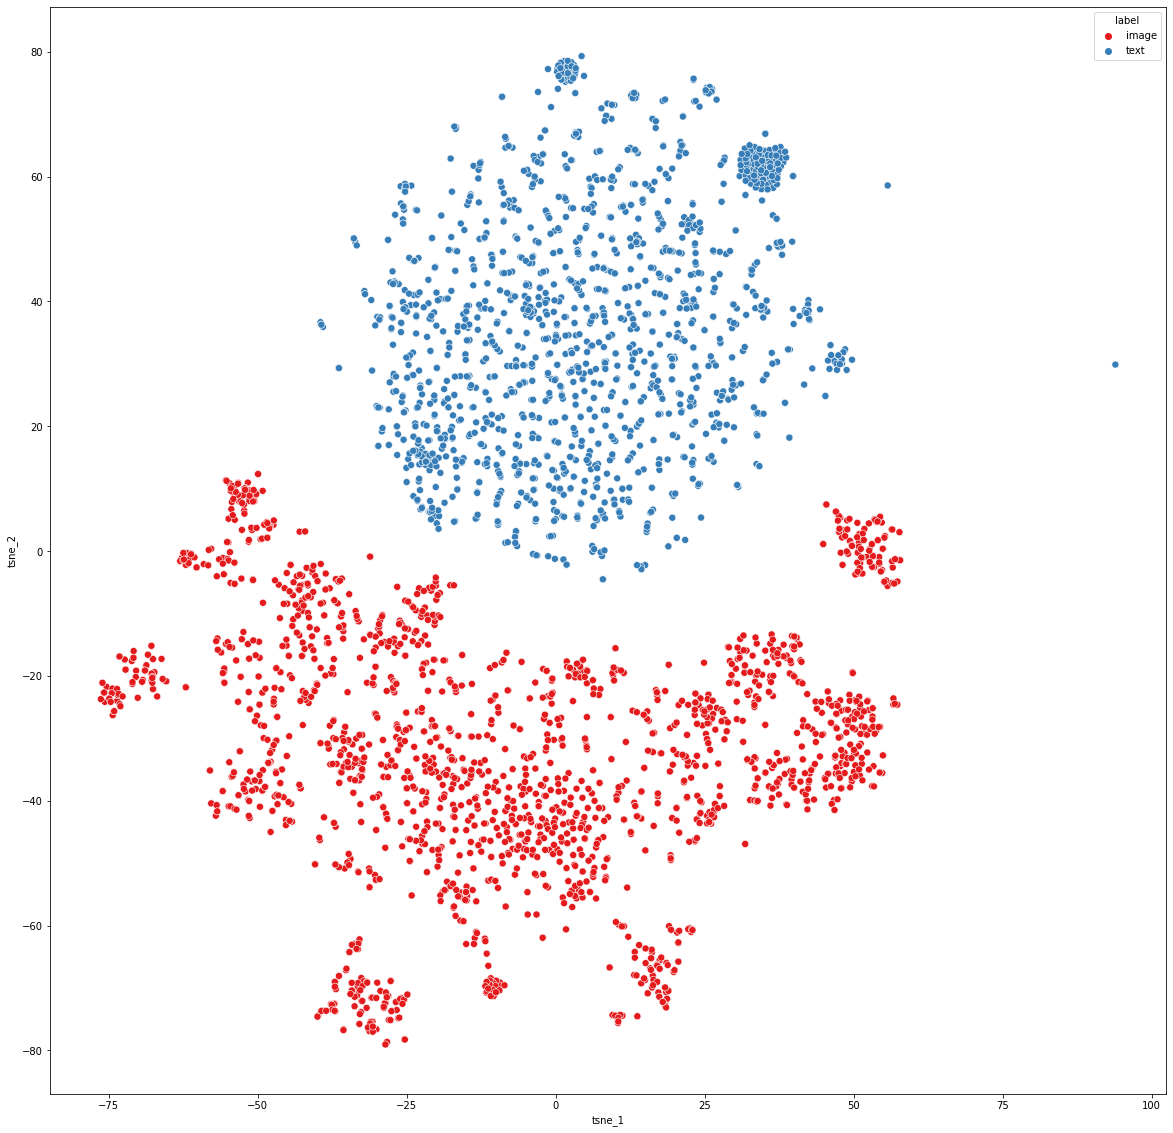

In [52]:
all_features = []
all_labels = []

for feature in all_image_features:
    all_features.append(feature)
    all_labels.append('image')
    
for feature in all_text_features:
    all_features.append(feature)
    all_labels.append('text')
        
sns.set_palette(sns.color_palette("Set1", len(all_labels)))
        
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(np.array(all_features))
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': all_labels})
fig = plt.figure(figsize=(20, 20))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, s=50, legend="full")
lim = (tsne_result.min()-5, tsne_result.max()+5) 

NameError: name 'DATA_DIR' is not defined